In [1]:
import keras
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import UpSampling2D
from keras.layers import Concatenate
from keras.layers import Lambda 
from keras.utils import to_categorical
import tensorflow as tf

from keras.layers import Reshape

from keras import backend as K
from keras import regularizers, optimizers
%matplotlib inline

Using TensorFlow backend.


In [2]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger,EarlyStopping,ModelCheckpoint

In [3]:
import scipy.io as scio
import numpy as np    
import os
import matplotlib.pyplot as plt
import math
import re
from scipy.misc import imsave
from scipy import ndimage, misc
from numpy import unravel_index
from operator import sub

In [4]:
def atoi(text) : 
    return int(text) if text.isdigit() else text

In [5]:
def natural_keys(text) :
    return [atoi(c) for c in re.split('(\d+)', text)]

In [6]:
def get_info(filenames, ext):
    images = []

    for filename in filenames :
        filepath = os.path.join(root,filename)
        if ext == '.npy':
            image = np.load(filepath)
            h,w = image.shape
            
            if h != 512 or w != 64:
#                 print(h,w) 
                amount = 512 - h
                id_full = np.full((amount, 64), 7)
                image = np.concatenate((image, id_full))
#                 print(image.shape)
        elif ext == '.tif':
            image = ndimage.imread(filepath, mode = "L")
        images.append(image)
    return images

In [7]:
root_path = ""
filenames = []
for root, dirnames, filenames in os.walk("/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/atrium_data/raw"):
    filenames.sort(key = natural_keys)
    rootpath = root

In [8]:
raw_images = get_info(filenames, '.tif')

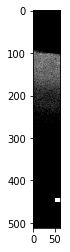

In [9]:
plt.imshow(raw_images[0],cmap = "gray")

In [10]:
print (raw_images[0].shape)

(512, 64)


In [11]:
root_path = ""
filenames = []
for root, dirnames, filenames in os.walk("/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/atrium_data/ids"):
    filenames.sort(key = natural_keys)
    rootpath = root

labels_list = get_info(filenames, '.npy')

In [20]:
print(labels_list[0].shape)
for ids in labels_list:

    h,w = ids.shape
    if h != 512 or w != 64:
    #         print(h,w)
        amount = 512 - h
        weight_full = np.full((amount, 64), 1.0)
        id_full = np.full((amount, 64), 7)
        weights = np.concatenate((weights, weight_full))
        ids = np.concatenate((ids, id_full))   
    new_id = np.copy(ids)
    for m in range(h):
        for n in range(w):
            if ids[m,n] > 7:
                # set all label values to 7 
                ids[m,n] = 7
print(np.unique(labels_list))

(512, 64)
[0 1 2 3 4 5 6 7]


In [21]:
train_labels = np.zeros((171,512,64,8))
# train_labels = np.full((171,512,64,8),0.000)

In [22]:
val = 1
for i in range(len(labels_list)) :
    for j in range(512) :
        for k in range(64):
            if(labels_list[i][j][k] == 0):
                train_labels[i][j][k][0] = val
            if(labels_list[i][j][k] == 1):
                train_labels[i][j][k][1] = val
            if(labels_list[i][j][k] == 2):
                train_labels[i][j][k][2] = val
            if(labels_list[i][j][k] == 3):
                train_labels[i][j][k][3] = val
            if(labels_list[i][j][k] == 4):
                train_labels[i][j][k][4] = val
            if(labels_list[i][j][k] == 5):
                train_labels[i][j][k][5] = val
            if(labels_list[i][j][k] == 6):
                train_labels[i][j][k][6] = val
            if(labels_list[i][j][k] == 7 or labels_list[i][j][k] == 255):
                train_labels[i][j][k][7] = val

In [23]:
train_labels.shape

(171, 512, 64, 8)

In [24]:
train_labels[0][0][0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.])

In [25]:
images=raw_images
images=np.array(images)
print(images.shape[0])
images = images.reshape(images.shape[0],512,64,1)

print(images[0].shape)
train_indices = np.random.choice(171,150,replace = False)
# print(sorted(train_indices))
# print(train_labels[170])

171
(512, 64, 1)


In [26]:
train_images_random = []
train_labels_random = []

for i in train_indices:
    train_images_random.append(images[i])
    train_labels_random.append(train_labels[i])

In [27]:
test_indices = [x for x in range(171) if x not in train_indices]
print(test_indices)
test_images = []
test_labels = []
for i in test_indices:
    test_images.append(images[i])
    test_labels.append(train_labels[i])

[3, 7, 9, 31, 33, 34, 36, 56, 61, 71, 72, 75, 79, 101, 119, 123, 125, 128, 141, 146, 169]


In [28]:
train_images = np.array(train_images_random)
train_labels = np.array(train_labels_random)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [29]:
train_images = train_images.astype('float32')
train_labels = train_labels.astype('float32')
test_images = test_images.astype('float32')
test_labels = test_labels.astype('float32')

In [30]:
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)

(150, 512, 64, 1)
(21, 512, 64, 1)
(150, 512, 64, 8)
(21, 512, 64, 8)


In [31]:
print (len(train_images))
print (len(train_labels))
print (np.array(train_labels).shape)

150
150
(150, 512, 64, 8)


In [32]:
train_images.shape

(150, 512, 64, 1)

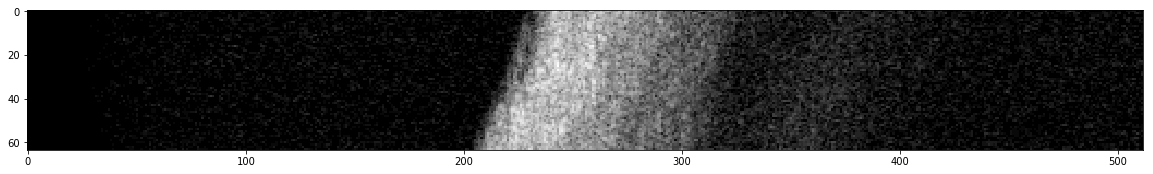

In [33]:
plt.figure(figsize=(20,10))
plt.imshow(np.rot90(train_images[0,:,:,0]), cmap=plt.cm.gray)

In [34]:
data_shape = 512*64

In [35]:
weight_decay = 0.0001

In [36]:
# Defines the input tensor
inputs = Input(shape=(512,64,1))

# init = 

L1 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(inputs)
L2 = BatchNormalization()(L1)
L2 = Activation('relu')(L2)
#L3 = Lambda(maxpool_1,output_shape = shape)(L2)
L3 = MaxPooling2D(pool_size=(2,2))(L2)
L4 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L3)
L5 = BatchNormalization()(L4)
L5 = Activation('relu')(L5)
#L6 = Lambda(maxpool_2,output_shape = shape)(L5)
L6 = MaxPooling2D(pool_size=(2,2))(L5)
L7 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L6)
L8 = BatchNormalization()(L7)
L8 = Activation('relu')(L8)
#L9 = Lambda(maxpool_3,output_shape = shape)(L8)
L9 = MaxPooling2D(pool_size=(2,2))(L8)
L10 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L9)
L11 = BatchNormalization()(L10)
L11 = Activation('relu')(L11)
L12 = UpSampling2D(size = (2,2))(L11)
#L12 = Lambda(unpool_3,output_shape = unpool_shape)(L11)
L13 = Concatenate(axis = 3)([L8,L12])
L14 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L13)
L15 = BatchNormalization()(L14)
L15 = Activation('relu')(L15)
L16 = UpSampling2D(size= (2,2))(L15)
#L16 = Lambda(unpool_2,output_shape=unpool_shape)(L15)
L17 = Concatenate(axis = 3)([L16,L5])
L18 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L17)
L19 = BatchNormalization()(L18)
L19 = Activation('relu')(L19)
#L20 = Lambda(unpool_1,output_shape=unpool_shape)(L19)
L20 = UpSampling2D(size=(2,2),name = "Layer19")(L19)
L21 = Concatenate(axis=3)([L20,L2])
L22 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L21)
L23 = BatchNormalization()(L22)
L23 = Activation('relu')(L23)
L24 = Conv2D(8,kernel_size=(1,1),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L23)
L = Reshape((data_shape,8),input_shape = (512,64,8))(L24)
L = Activation('softmax')(L)
model = Model(inputs = inputs, outputs = L)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 512, 64, 1)    0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 512, 64, 64)   640         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 512, 64, 64)   256         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 512, 64, 64)   0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [37]:
root_path = ""
filenames = []
for root, dirnames, filenames in os.walk("/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/atrium_data/weights"):
    filenames.sort(key = natural_keys)
    rootpath = root

weights = get_info(filenames, '.npy')

In [38]:
print(weights[0][0][0])

1.0


In [39]:
np.unique(weights)

array([  1.   ,   4.336,   6.63 ,   7.   ,  12.007,  12.459,  14.647,
        15.368,  17.978,  19.336,  21.63 ,  27.007,  27.459,  29.647,
        30.368,  32.978])

In [40]:
weights[0].shape

(512, 64)

In [41]:
len(weights)

171

In [42]:
weights_matrix = []
for i in train_indices:
    weights_matrix.append(weights[i])

In [43]:
len(weights_matrix)

150

In [44]:
sample_weights = weights_matrix

In [45]:
sample_weights = np.reshape(sample_weights,(150,data_shape))

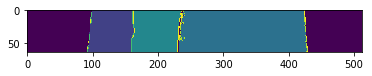

In [46]:
plt.imshow(np.rot90(np.reshape(weights[0],( 512,64)) ))

In [47]:
sample_weights.shape

(150, 32768)

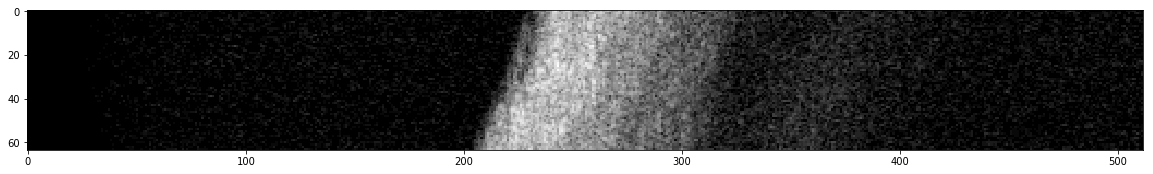

In [48]:
plt.figure(figsize=(20,10))
plt.imshow(np.rot90(train_images[0,:,:,0]), cmap=plt.cm.gray)

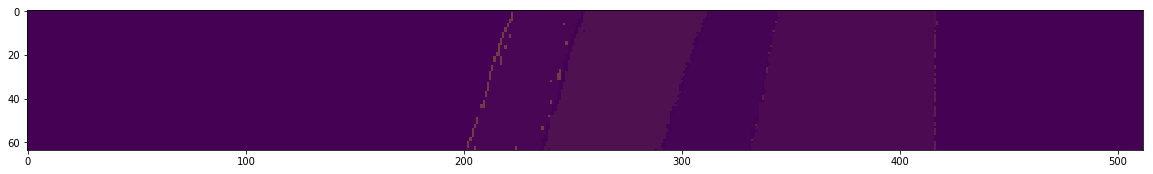

In [49]:
plt.figure(figsize=(20,10))
for i in range(7):
    plt.imshow(np.rot90(train_labels[0,:,:,i]), alpha=0.5)

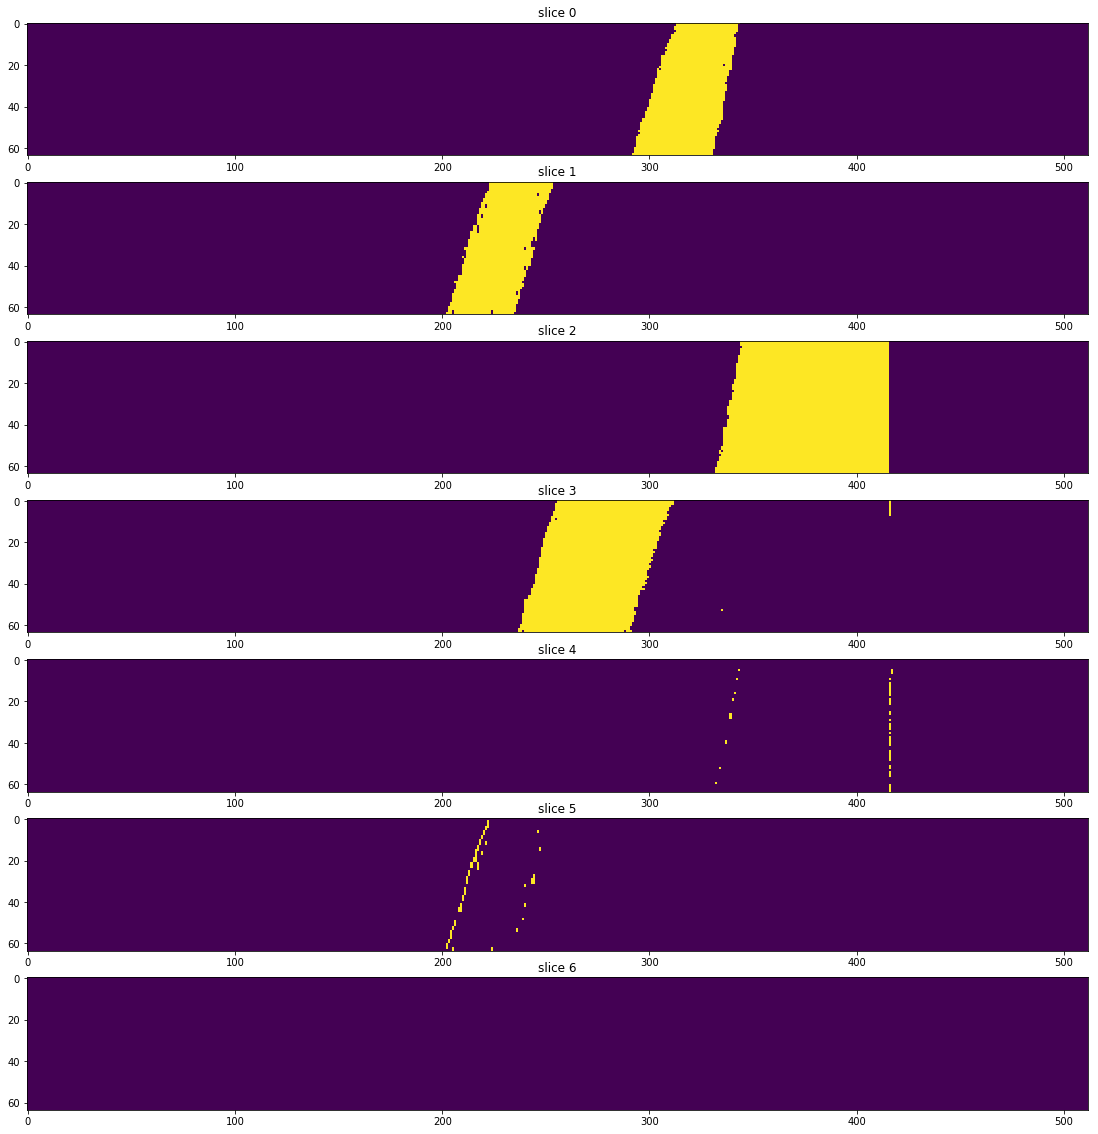

In [50]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(20,20))
for i, ax in enumerate(axes):
    ax.imshow(np.rot90(train_labels[0,:,:,i]))
    ax.set_title("slice " + str(i))

In [51]:
# first value is number of images
train_labels.shape


(150, 512, 64, 8)

In [52]:
train_labels = np.reshape(train_labels,(150,data_shape,8))
test_labels = np.reshape(test_labels,(21,data_shape,8))

In [53]:
train_labels.shape

(150, 32768, 8)

In [54]:
np.unique(train_labels)

array([ 0.,  1.], dtype=float32)

In [55]:
count = np.zeros(8)

In [56]:
# for i in range(150):
#     for j in range(32768):
#         for k in range(7):
#             if(train_labels[i][j][k]==1):
#                 count[k] = count[k]+1

In [57]:
# count = np.sum(train_labels==1,axis=(0,1))
count = np.sum(train_labels==val,axis=(0,1))

In [58]:
for i in range(8):
    print(count[i])

266704
296322
1343834
215056
150392
150096
297
2492499


In [59]:
count

array([ 266704,  296322, 1343834,  215056,  150392,  150096,     297,
       2492499])

In [60]:
median = np.median(count)

In [61]:
median

240880.0

In [62]:
scale = np.zeros(8)

In [63]:
for i in range(8):
    scale[i] = (median/count[i])

In [64]:
scale.min()

0.096641964550437137

In [65]:
weights = np.zeros(8)
for i in range(8):
    weights[i] = scale[i]/scale.min()

In [66]:
weights = sorted(weights)

In [67]:
smooth = 1

In [68]:
def dice_coef(y_true, y_pred):
    '''
    y_true = label
    y_pred = prediction
    '''
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [69]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [70]:
def customized_loss(y_true,y_pred):
    cross_ent = K.categorical_crossentropy(y_true, y_pred)
    loss_dice_coef = dice_coef_loss(y_true, y_pred)
    print(y_true, y_pred)
    print(cross_ent)
    print(dice_coef)
    return (1 * cross_ent)+(0.5*loss_dice_coef)

In [71]:
train_labels.shape

(150, 32768, 8)

In [72]:
k = np.array(train_labels_random)

In [73]:
np.random.shuffle(k)

In [74]:
k = k.reshape((k.shape[0], k.shape[1]*k.shape[2], k.shape[3]))

In [75]:
k.shape

(150, 32768, 8)

In [76]:
# k = tf.convert_to_tensor(k, dtype=np.float64)
# l = tf.convert_to_tensor(train_labels, dtype=np.float64)
# print(l)
# s = customized_loss(l[0], k[0])
# np.max(s)

In [77]:
# print(l[0])
# print(k[0])

In [78]:
# x = K.categorical_crossentropy(l[0], k[0])
# init_g = tf.global_variables_initializer()
# init_l = tf.local_variables_initializer()
# with tf.Session() as sess:
#     sess.run(init_g)
#     sess.run(init_l)
#     el = l[0].eval(session=sess)
#     kel = k[0].eval(session=sess)
#     dice_coef = dice_coef_loss(l[0], k[0]).eval(session=sess)
#     cross_ent = K.categorical_crossentropy(l[0], k[0]).eval(session=sess)
#     sim=s.eval(session=sess)
# print(el.shape,el.max(),el.min(), np.unique(el)) # they're encoded correctly and have only values 0 to 1
# print(kel.shape,kel.max(),kel.min(), np.unique(kel))
# print(dice_coef)
# print(cross_ent.shape,cross_ent)
# print(sim.shape, sim)

In [79]:
# model.predict(train_images[:2])

In [80]:
# # Define model

# from keras.layers import Input, Dense
# from keras.models import Model

# inputs = Input(shape=(512,64,1))

# # input = Input(shape=[2])
# # probs = Dense(1, activation='sigmoid')(input)

# # model = Model(input=input, output=probs)
# model.compile(optimizer='sgd', loss='binary_crossentropy')

# # Get gradient tensors
# weights = model.trainable_weights # weight tensors
# # weights = [weight for weight in weights if model.get_layer(weight.name[:-2]).trainable] # filter down weights tensors to only ones which are trainable
# gradients = model.optimizer.get_gradients(model.total_loss, weights) # gradient tensors

# # print(weights)
# # ==> [dense_1_W, dense_1_b]

# # Define keras function to return gradients
# import keras.backend as K

# input_tensors = [model.inputs[0], # input data
#                  model.sample_weights[0], # how much to weight each sample by
#                  model.targets[0], # labels
#                  K.learning_phase(), # train or test mode
# ]

# get_gradients = K.function(inputs=input_tensors, outputs=gradients)

# # Get gradients of weights for particular (X, sample_weight, y, learning_mode) tuple
# from keras.utils.np_utils import to_categorical

# print(type(inputs))
# print(zip(weights, get_gradients(inputs[0])))
# # ==> [(dense_1_W, array([[-0.42342907],
# #                          [-0.84685814]], dtype=float32)),
# #       (dense_1_b, array([-0.42342907], dtype=float32))]

In [81]:
optimiser = optimizers.Adam(lr = 0.01)
# optimiser = optimizers.Adam(lr = 10**-15, clipvalue=0.5)

In [82]:
smooth=1

In [83]:
model.compile(optimizer=optimiser,loss=customized_loss,metrics=['accuracy',dice_coef],sample_weight_mode='temporal')

Tensor("activation_8_target:0", shape=(?, ?, ?), dtype=float32) Tensor("activation_8/truediv:0", shape=(?, 32768, 8), dtype=float32)
Tensor("Neg:0", shape=(?, 32768), dtype=float32)
<function dice_coef at 0x7f7dfddad510>


In [84]:
train_images[0].shape

(512, 64, 1)

In [85]:
#Defining Callback functions which will be called by model during runtime when specified condition satisfies
lr_reducer = ReduceLROnPlateau(factor=0.5, cooldown=0, patience=6, min_lr=0.5e-6)
csv_logger = CSVLogger('Relaynet_sample_weights_denoised_lr_e2_testing_bs_20.csv')
model_chekpoint = ModelCheckpoint("Relaynet_sample_weights_denoised_lr_e2_testing_bs_20.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)

In [ ]:
# val = 150
# train_images = train_images[:val]
# train_labels = train_labels[:val]
# test_images = test_images
# test_labels = test_labels
# sample_weights = sample_weights[:val]

In [ ]:
model.fit(train_images,train_labels,batch_size=40,epochs=50,validation_data=(test_images,test_labels),sample_weight=sample_weights,callbacks=[lr_reducer, csv_logger,model_chekpoint])

Train on 150 samples, validate on 21 samples
Epoch 1/50
150/150 [==============================] - 176s - loss: 80.3025 - acc: 0.3220 - dice_coef: 0.2348 - val_loss: 7.6356 - val_acc: 0.5148 - val_dice_coef: 0.5150
Epoch 2/50
150/150 [==============================] - 172s - loss: 55.0512 - acc: 0.4195 - dice_coef: 0.3525 - val_loss: 14.6833 - val_acc: 0.0923 - val_dice_coef: 0.0923
Epoch 3/50
 80/150 [===============>..............] - ETA: 76s - loss: 48.2099 - acc: 0.4077 - dice_coef: 0.3948 

In [ ]:
model.load_weights("/home/sim/notebooks/relaynet_pytorch/Relaynet_sample_weights_denoised_lr_e2_testing_bs_20.hdf5")

In [ ]:
testing_image = train_images[28]

In [ ]:
testing_image.shape

In [ ]:
testing_image = np.squeeze(testing_image,axis = 2)

In [ ]:
testing_image.shape

In [ ]:
plt.imshow(testing_image,cmap = "gray")

In [ ]:
plt.show()
testing_image = testing_image.reshape((1,512,64,1))
prediction = model.predict(testing_image)
prediction = np.squeeze(prediction,axis = 0)
print(prediction.shape)

np.argmax(prediction[6999])

prediction = np.reshape(prediction,(512,64,8))
output = np.zeros((512,64))
ground = np.zeros((512,64))
for i in range(512):
    for j in range(64):
        index = np.argmax(prediction[i][j])
        output[i][j] = index
test_labels[0].shape

test_labels[120][6999]

test_ground_truth = np.reshape(train_labels[28],(512,64,8))
for i in range(512):
    for j in range(64):
        index = np.argmax(test_ground_truth[i][j])
        ground[i][j] = index
for i in range(512):
    for j in range(64):
        index = np.argmax(prediction[i][j])
        output[i][j] = index
print (output.shape)

color= np.zeros((512,64,3))
c0 = 0
c1 = 0
c2 = 0
c3 = 0
c4 = 0
c5 = 0
c6 = 0
c7 = 0
for j in range(512):
    for k in range(64):
        if output[j][k] != 0:
            print(output[j][k])
        if(output[j][k]==0):
            c0 = c0 + 1
            color[j][k] = [0,0,0]
        if(output[j][k]==1):
            c1 = c1 + 1
            color[j][k] = [128,0,0]
        if(output[j][k]==2):
            c2 = c2 + 1
            color[j][k] = [0,128,0]
        if(output[j][k]==3):
            c3 = c3 + 1
            color[j][k] = [128,128,0] 
        if(output[j][k]==4):
            c4 = c4 + 1
            color[j][k] = [0,128,128]
        if(output[j][k]==5):
            c5 = c5 + 1
            color[j][k] = [64,0,0]
        if(output[j][k]==6):
            c6 = c6 + 1
            color[j][k] = [192,0,0]
        if(output[j][k]==7):
            c7 = c7 + 1
            color[j][k] = [0,0,0]

print(c0)
print(c1)
print(c2)
print(c3)
print(c4)
print(c5)
print(c6)
print(c7)

%matplotlib inline
plt.imshow(color)